In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from mpl import estimation
from sklearn import metrics
from sklearn import model_selection


In [2]:
itch_dt = pd.read_csv('data/itch_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                        "Condition":"condition",
                        "Question":"question_id",
                        "X1":"ss_x",
                        "T1":"ss_t",
                        "X2":"ll_x",
                        "T2":"ll_t",
                        "G":"abs_diff_x",
                        "D":"abs_diff_t",
                        "R":"ratio_x",
                        "LaterOptionChosen": "choice"})


itch_dt['rel_diff_x'] = 2*(itch_dt['ll_x'] - itch_dt['ss_x'])/(itch_dt['ll_x'] + itch_dt['ss_x']) 
itch_dt['rel_diff_t'] = 2*(itch_dt['ll_t'] - itch_dt['ss_t'])/(itch_dt['ll_t'] + itch_dt['ss_t']) 
itch_dt['growth_x'] = np.log(itch_dt['ratio_x']) / itch_dt['abs_diff_t']

itch_dt


,person_id,condition,question_id,abs_diff_x,ratio_x,abs_diff_t,ss_x,ss_t,ll_x,ll_t,choice,rel_diff_x,rel_diff_t,growth_x
0,259,4,1,0.5,1.50,1,1.00,2,1.50,3,0.0,0.400000,0.400000,0.405465
1,259,4,2,2.0,4.00,1,0.67,0,2.67,1,0.0,1.197605,2.000000,1.386294
2,259,4,3,10.0,1.01,1,1000.00,2,1010.00,3,0.0,0.009950,0.400000,0.009950
3,259,4,4,0.5,4.00,2,0.17,0,0.67,2,0.0,1.190476,2.000000,0.693147
4,259,4,5,10.0,1.50,2,20.00,0,30.00,2,0.0,0.400000,2.000000,0.202733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23495,793,1,21,10.0,1.25,3,40.00,2,50.00,5,1.0,0.222222,0.857143,0.074381
23496,793,1,22,100.0,2.00,1,100.00,0,200.00,1,1.0,0.666667,2.000000,0.693147
23497,793,1,23,500.0,2.00,3,500.00,0,1000.00,3,1.0,0.666667,2.000000,0.231049
23498,793,1,24,10.0,1.01,2,1000.00,2,1010.00,4,0.0,0.009950,0.666667,0.004975


In [90]:
dataset = itch_dt.dropna()

features = ['ss_x', 'ss_t', 'll_x', 'll_t','abs_diff_x', 'abs_diff_t', 
                   'rel_diff_x','rel_diff_t','growth_x']
label = ['choice']

param_grid = {'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.6],
              'colsample_bytree': [1.0]
            }

X = dataset[features]
y = dataset[label]
groups = dataset['person_id']


model = xgb.XGBClassifier(objective='binary:logistic')

sgkf = model_selection.StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=2023)

cv = list(sgkf.split(X,y,groups))

grid_search = model_selection.GridSearchCV(model, param_grid, cv=cv, 
                                           scoring="neg_log_loss", refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X, y, groups=groups)

# model = xgb.XGBClassifier(objective='binary:logistic',
#                           max_depth=3,
#                           learning_rate=.1,
#                           gamma=.3,
#                           reg_lambda=.7,
#                           subsample=.6,
#                           colsample_bytree=1.0,
#                           eval_metric=['error','logloss'],
#                           early_stopping_rounds=30)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# bst = model.fit(X=X_train,
#                 y=y_train,
#                 eval_set=eval_set,
#                 verbose=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 23128, 23129, 23130]),
                  array([  192,   193,   194, ..., 22906, 22907, 22908])),
                 (array([    0,     1,     2, ..., 23103, 23104, 23105]),
                  array([   74,    75,    76, ..., 23128, 23129, 23130])),
                 (array([    0,     1,     2, ..., 23128, 23129, 23130]),
                  array([  217,   218,   219, ..., 23030, 23031, 23032])),
                 (array([    0,     1,     2, ..., 23128, 23129, 23130]),
                  array([  416,   417,   418, ..., 23079, 23080, 23081])),
                 (array([...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'reg_lambda': [0.7], 'subsample': [0.6]},
             refit='neg_log_loss', scoring='neg_log_loss', verbose=3)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0.7, 'subsample': 0.6}
Best score: -0.582672705915251


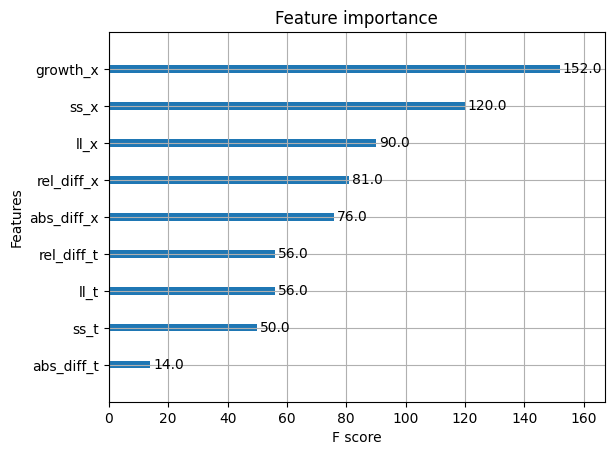

In [129]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
bst_model = grid_search.best_estimator_
xgb.plot_importance(bst_model)
with open('my_model.pkl', 'wb') as f:
    pickle.dump(bst_model, f)

In [134]:
train_index,test_index = list(model_selection.GroupShuffleSplit(n_splits=1,random_state=2023).split(X,y,groups))[0]

train_sample = dataset[dataset.index.isin(train_index)]
test_sample = dataset[dataset.index.isin(test_index)]

with open('my_model.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

preds = heuristic_model.predict(test_sample[features])
trues = test_sample[label]

pred_binary = [int(x > 0.5) for x in preds]

print(metrics.accuracy_score(trues, pred_binary))
print(metrics.roc_auc_score(trues, preds))
print(metrics.log_loss(trues, preds))
print(metrics.mean_squared_error(trues, preds))

0.7038411174159755
0.657057714970168
10.674648111966821


In [15]:
xgb.to_graphviz(bst_model, num_trees=1)

ImportError: You must install graphviz to plot tree

In [143]:
style = {'dstyle':"attention",'ustyle':'power','method':"logit"}
train_result = estimation.mle(style=style,data=train_sample,disp_output=False)
cross_valid.test_model(style=style,test_sample=test_sample,params=train_result["params"])

                    message: ['success condition satisfied']
                    success: True
                        fun: 0.6116941735636527
                          x: [ 9.993e-01  4.267e+00  2.926e-01  8.972e-01]
                        nit: 130
      minimization_failures: 8
                       nfev: 14930
                       njev: 2986
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.6116941735636527
                                    x: [ 9.993e-01  4.267e+00  2.926e-01
                                         8.972e-01]
                                  nit: 8
                                  jac: [-1.413e-02  1.229e-03 -1.571e-02
                                         1.074e-02]
                                 nfev: 385
                                 njev: 77
                             hess_inv: <4x4

{'mse': 0.1516203262567255,
 'mae': 0.36728255581073,
 'accuracy': 0.8566128328240943,
 'log_loss': 0.47872087108841754}

In [144]:
aux_sample = test_sample
aux_sample['choice'] = pred_binary
cross_valid.test_model(style=style,test_sample=aux_sample,params=train_result["params"])

C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_10436\230270245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_sample['choice'] = pred_binary


{'mse': 0.1516203262567255,
 'mae': 0.36728255581073,
 'accuracy': 0.8566128328240943,
 'log_loss': 0.47872087108841754}